# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [2]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from exercise_code.classifiers.fc_net import *
from exercise_code.data_utils import get_CIFAR10_data
from exercise_code.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from exercise_code.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (48000, 3, 32, 32)
y_train:  (48000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `exercise_code/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [4]:
from exercise_code.layer_utils import affine_relu_forward, affine_relu_backward

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  6.484338206721099e-10
dw error:  2.0136475546758605e-10
db error:  9.175231937139225e-12


# Multilayer network

## Initial loss and gradient check

As a sanity check, let's run the following to check the initial loss and to gradient check the network both with and without regularization. 

For gradient checking, you we expect to see errors around 1e-6 or less.

In [5]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.29210976521641
W0 relative error: 4.51e-08
W1 relative error: 1.36e-07
W2 relative error: 1.24e-07
b0 relative error: 2.21e-09
b1 relative error: 3.82e-09
b2 relative error: 7.23e-11
Running check with reg =  3.14
Initial loss:  5.714876175033646
W0 relative error: 2.01e-08
W1 relative error: 2.91e-08
W2 relative error: 1.00e+00
b0 relative error: 1.20e-07
b1 relative error: 2.14e-08
b2 relative error: 1.00e+00


As another sanity check, let's make sure that we can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% **training** accuracy within 20 epochs.

(Iteration 1 / 40) loss: 361.464754
(Epoch 0 / 20) train acc: 0.280000; val_acc: 0.104000
(Epoch 1 / 20) train acc: 0.220000; val_acc: 0.099000
(Epoch 2 / 20) train acc: 0.420000; val_acc: 0.104000
(Epoch 3 / 20) train acc: 0.600000; val_acc: 0.118000
(Epoch 4 / 20) train acc: 0.820000; val_acc: 0.148000
(Epoch 5 / 20) train acc: 0.920000; val_acc: 0.137000
(Iteration 11 / 40) loss: 1.973914
(Epoch 6 / 20) train acc: 0.940000; val_acc: 0.156000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.143000
(Epoch 8 / 20) train acc: 0.980000; val_acc: 0.143000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.143000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.148000
(Iteration 21 / 40) loss: 0.000000
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.148000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.148000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.148000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.148000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.148000
(Iteration 31 / 40) loss

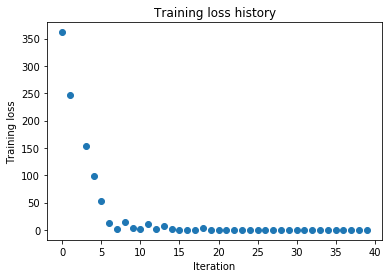

In [6]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

#############################################################################
# TODO: Maybe tweak values                                                  #
#############################################################################
weight_scale = 1e-1
learning_rate = 1e-3

model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now let's try to use a five-layer network with 100 units on each layer to overfit 50 training examples. 

(Iteration 1 / 40) loss: 180.446744
(Epoch 0 / 20) train acc: 0.300000; val_acc: 0.118000
(Epoch 1 / 20) train acc: 0.080000; val_acc: 0.111000
(Epoch 2 / 20) train acc: 0.460000; val_acc: 0.102000
(Epoch 3 / 20) train acc: 0.540000; val_acc: 0.137000
(Epoch 4 / 20) train acc: 0.640000; val_acc: 0.127000
(Epoch 5 / 20) train acc: 0.820000; val_acc: 0.124000
(Iteration 11 / 40) loss: 4.910850
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.132000
(Epoch 7 / 20) train acc: 0.920000; val_acc: 0.126000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.131000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.127000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.126000
(Iteration 21 / 40) loss: 0.000169
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.134000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.135000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.135000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.135000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.135000
(Iteration 31 / 40) loss

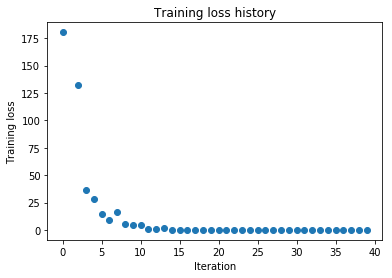

In [7]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

#############################################################################
# TODO: Maybe tweak values                                                  #
#############################################################################
learning_rate = 1e-3
weight_scale = 1e-1
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?</p>
</div>


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

In [8]:
from exercise_code.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 400) loss: 2.299962
(Epoch 0 / 10) train acc: 0.090000; val_acc: 0.127000
(Iteration 11 / 400) loss: 2.310378
(Iteration 21 / 400) loss: 2.298932
(Iteration 31 / 400) loss: 2.293529
(Epoch 1 / 10) train acc: 0.167000; val_acc: 0.164000
(Iteration 41 / 400) loss: 2.287463
(Iteration 51 / 400) loss: 2.291755
(Iteration 61 / 400) loss: 2.296128
(Iteration 71 / 400) loss: 2.285109
(Epoch 2 / 10) train acc: 0.182000; val_acc: 0.195000
(Iteration 81 / 400) loss: 2.282070
(Iteration 91 / 400) loss: 2.279780
(Iteration 101 / 400) loss: 2.272080
(Iteration 111 / 400) loss: 2.266855
(Epoch 3 / 10) train acc: 0.190000; val_acc: 0.223000
(Iteration 121 / 400) loss: 2.261915
(Iteration 131 / 400) loss: 2.246698
(Iteration 141 / 400) loss: 2.243930
(Iteration 151 / 400) loss: 2.222877
(Epoch 4 / 10) train acc: 0.198000; val_acc: 0.213000
(Iteration 161 / 400) loss: 2.169267
(Iteration 171 / 400) loss: 2.166742
(Iteration 181 / 400) loss: 2.094690
(Iteration 191 / 400

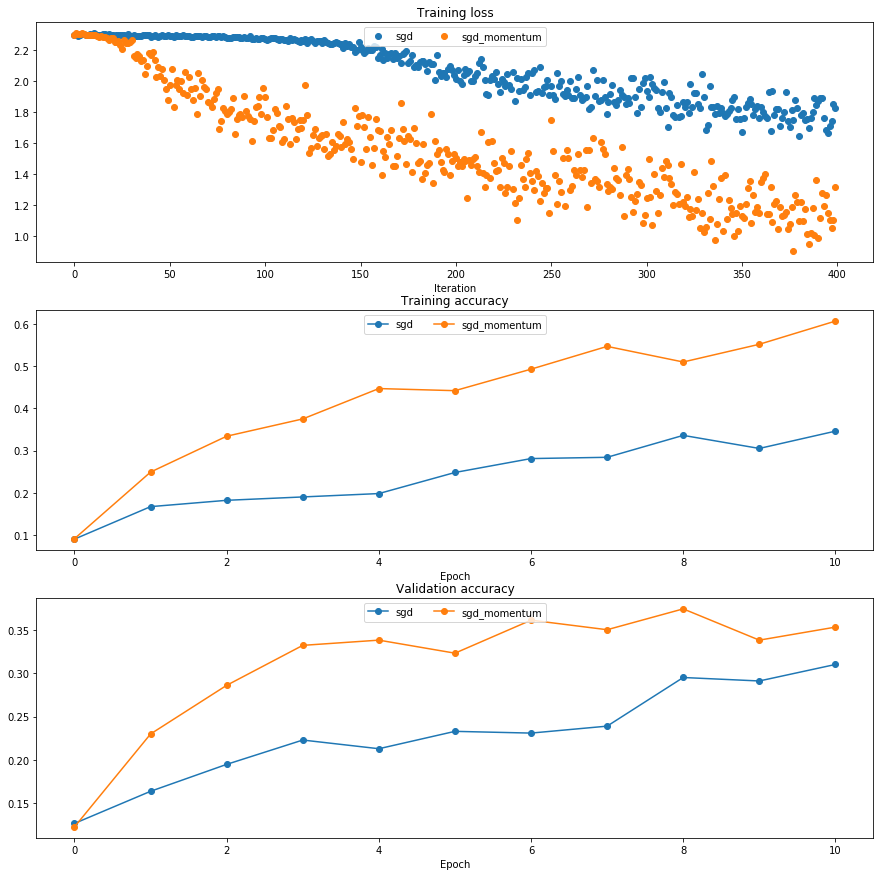

In [16]:
num_train = 4000
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=3e-2)

    solver = Solver(model, small_data,
                    num_epochs=10, batch_size=100,
                    update_rule=update_rule,
                    optim_config={'learning_rate': 1e-2},
                    verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)
  
    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Adam
Let's try Adam now

running with  adam
(Iteration 1 / 200) loss: 2.790243
(Epoch 0 / 5) train acc: 0.175000; val_acc: 0.165000
(Iteration 11 / 200) loss: 1.939068
(Iteration 21 / 200) loss: 1.933714
(Iteration 31 / 200) loss: 1.858927
(Epoch 1 / 5) train acc: 0.411000; val_acc: 0.319000
(Iteration 41 / 200) loss: 1.857555
(Iteration 51 / 200) loss: 1.739692
(Iteration 61 / 200) loss: 1.739417
(Iteration 71 / 200) loss: 1.589982
(Epoch 2 / 5) train acc: 0.466000; val_acc: 0.362000
(Iteration 81 / 200) loss: 1.406390
(Iteration 91 / 200) loss: 1.345620
(Iteration 101 / 200) loss: 1.433677
(Iteration 111 / 200) loss: 1.547966
(Epoch 3 / 5) train acc: 0.522000; val_acc: 0.355000
(Iteration 121 / 200) loss: 1.357673
(Iteration 131 / 200) loss: 1.561039
(Iteration 141 / 200) loss: 1.424040
(Iteration 151 / 200) loss: 1.490242
(Epoch 4 / 5) train acc: 0.531000; val_acc: 0.352000
(Iteration 161 / 200) loss: 1.503897
(Iteration 171 / 200) loss: 1.385156
(Iteration 181 / 200) loss: 1.152208
(Iteration 191 / 200) lo

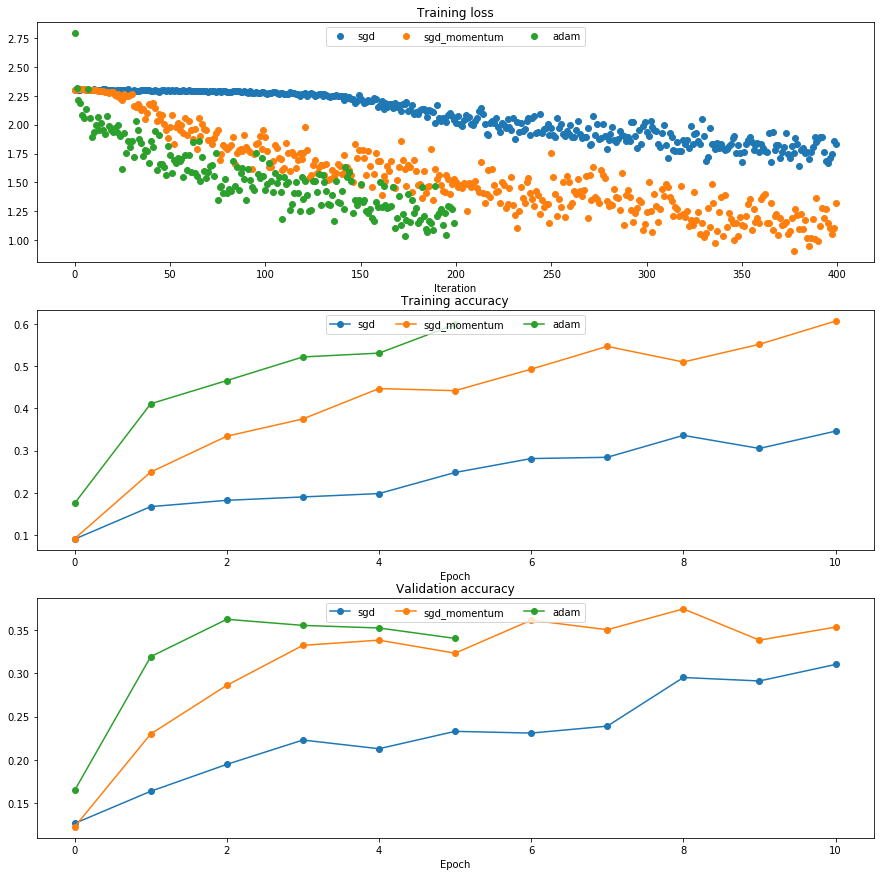

In [17]:
learning_rates = {'adam': 1e-3}
update_rule = 'adam'
print('running with ', update_rule)
model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

solver = Solver(model, small_data,
              num_epochs=5, batch_size=100,
              update_rule=update_rule,
              optim_config={
                'learning_rate': learning_rates[update_rule]
              },
              verbose=True)
solvers[update_rule] = solver
solver.train()
print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)
  
    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
    
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least __50%__ accuracy on the validation set using a fully-connected net.

You might find it useful to complete the `2_BatchNormalization.ipynb` and the `3_Dropout.ipynb` notebooks before completing this part, since these techniques can help you train powerful models.

In [18]:
best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
# Note that dropout is not required to pass beyond the linear scoring regime   #
################################################################################
learning_rates = {'adam': 1e-2}
update_rule = 'adam'
print('running with ', update_rule)
model = FullyConnectedNet([100, 100, 100, 100], weight_scale=5e-2, use_batchnorm=True, dropout=0.7)

solver = Solver(model, data,
              num_epochs=10, batch_size=100,
              update_rule=update_rule,
              optim_config={
                'learning_rate': learning_rates[update_rule]
              },
              verbose=True)
solver.train()
print()
best_model = model
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

running with  adam
(Iteration 1 / 4800) loss: 2.351671
(Epoch 0 / 10) train acc: 0.136000; val_acc: 0.142000
(Iteration 11 / 4800) loss: 2.074709
(Iteration 21 / 4800) loss: 2.011255
(Iteration 31 / 4800) loss: 1.777353
(Iteration 41 / 4800) loss: 1.941234
(Iteration 51 / 4800) loss: 1.798534
(Iteration 61 / 4800) loss: 1.813059
(Iteration 71 / 4800) loss: 1.794867
(Iteration 81 / 4800) loss: 1.829432
(Iteration 91 / 4800) loss: 1.799339
(Iteration 101 / 4800) loss: 1.961858
(Iteration 111 / 4800) loss: 1.709671
(Iteration 121 / 4800) loss: 1.727689
(Iteration 131 / 4800) loss: 1.904766
(Iteration 141 / 4800) loss: 1.693733
(Iteration 151 / 4800) loss: 1.712955
(Iteration 161 / 4800) loss: 1.649632
(Iteration 171 / 4800) loss: 1.713639
(Iteration 181 / 4800) loss: 1.690437
(Iteration 191 / 4800) loss: 1.832964
(Iteration 201 / 4800) loss: 1.670279
(Iteration 211 / 4800) loss: 1.575018
(Iteration 221 / 4800) loss: 1.488385
(Iteration 231 / 4800) loss: 1.585474
(Iteration 241 / 4800) los

(Iteration 2071 / 4800) loss: 1.334913
(Iteration 2081 / 4800) loss: 1.170877
(Iteration 2091 / 4800) loss: 1.306944
(Iteration 2101 / 4800) loss: 1.140969
(Iteration 2111 / 4800) loss: 1.353732
(Iteration 2121 / 4800) loss: 1.231853
(Iteration 2131 / 4800) loss: 1.205796
(Iteration 2141 / 4800) loss: 1.260277
(Iteration 2151 / 4800) loss: 1.254493
(Iteration 2161 / 4800) loss: 1.202191
(Iteration 2171 / 4800) loss: 1.197533
(Iteration 2181 / 4800) loss: 1.429703
(Iteration 2191 / 4800) loss: 1.283624
(Iteration 2201 / 4800) loss: 1.174414
(Iteration 2211 / 4800) loss: 1.277028
(Iteration 2221 / 4800) loss: 1.244007
(Iteration 2231 / 4800) loss: 1.266329
(Iteration 2241 / 4800) loss: 1.293076
(Iteration 2251 / 4800) loss: 1.367639
(Iteration 2261 / 4800) loss: 1.321272
(Iteration 2271 / 4800) loss: 1.176468
(Iteration 2281 / 4800) loss: 1.227356
(Iteration 2291 / 4800) loss: 1.276253
(Iteration 2301 / 4800) loss: 1.171469
(Iteration 2311 / 4800) loss: 1.234448
(Iteration 2321 / 4800) l

(Iteration 4121 / 4800) loss: 0.999054
(Iteration 4131 / 4800) loss: 1.202018
(Iteration 4141 / 4800) loss: 1.147347
(Iteration 4151 / 4800) loss: 0.979217
(Iteration 4161 / 4800) loss: 1.211144
(Iteration 4171 / 4800) loss: 1.202006
(Iteration 4181 / 4800) loss: 1.311232
(Iteration 4191 / 4800) loss: 0.978242
(Iteration 4201 / 4800) loss: 1.138693
(Iteration 4211 / 4800) loss: 1.060873
(Iteration 4221 / 4800) loss: 1.034822
(Iteration 4231 / 4800) loss: 1.364483
(Iteration 4241 / 4800) loss: 1.175232
(Iteration 4251 / 4800) loss: 1.074327
(Iteration 4261 / 4800) loss: 1.158963
(Iteration 4271 / 4800) loss: 1.043635
(Iteration 4281 / 4800) loss: 0.888407
(Iteration 4291 / 4800) loss: 0.988147
(Iteration 4301 / 4800) loss: 1.201008
(Iteration 4311 / 4800) loss: 1.103830
(Epoch 9 / 10) train acc: 0.619000; val_acc: 0.538000
(Iteration 4321 / 4800) loss: 0.990286
(Iteration 4331 / 4800) loss: 1.021071
(Iteration 4341 / 4800) loss: 1.057614
(Iteration 4351 / 4800) loss: 0.986951
(Iteration

# Test your model
Run your best model on the validation and test sets. You should achieve score of above __50%__ accuracy on the validation set.

In [19]:
X_test = data['X_test']
X_val = data['X_val']
y_val = data['y_val']
y_test = data['y_test']

y_test_pred = np.argmax(best_model.loss(X_test), axis=1)
y_val_pred = np.argmax(best_model.loss(X_val), axis=1)
print('Validation set accuracy: ', (y_val_pred == y_val).mean())
print('Test set accuracy: ', (y_test_pred == y_test).mean())

Validation set accuracy:  0.543
Test set accuracy:  0.543


## Save the model

When you are satisfied with your training, save the model for submission.

<div class="alert alert-danger">
    <h3>Warning</h3>
    <p>You might get an error like this:</p>
    <p>PicklingError: Can't pickle <class 'exercise_code.classifiers.softmax.SoftmaxClassifier'>: it's not the same object as exercise_code.classifiers.softmax.SoftmaxClassifier</p>
    <p>The reason is that we are using autoreload and working on this class during the notebook session. If you get this error simply restart the kernel and rerun the whole script (Kernel -> Restart & Run All) or only the important cells for generating your model.</p>
</div>

In [20]:
from exercise_code.model_savers import save_fully_connected_net
save_fully_connected_net(best_model)